# Natural Language Processing and Information Extraction
## Deep learning - practical session

__Nov 22, 2024__

__Varvara Arzt__

The material of this lecture was created by __Ádám Kovács__ and extended by Varvara Arzt

<a href="https://colab.research.google.com/github/tuw-nlp-ie/tuw-nlp-ie-2024WS/blob/main/lectures/05_Deep_learning_practical_lesson/deep_learning_practical_lesson_with_outputs.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

During this lecture we are going to use a classification dataset from a shared task: [SemEval 2019 - Task 6](https://github.com/ZeyadZanaty/offenseval).

SemEval (Semantic Evaluation) is a series of international NLP research workshops whose mission is to advance the current SOTA in semantic analysis. [Here](https://github.com/SemEval/SemEval2025/blob/main/tasks.md) you can find a list of shared tasks for SemEval-2025.

The [SemEval 2019 - Task 6](https://github.com/ZeyadZanaty/offenseval) is about Identifying and Categorizing Offensive Language in Social Media.
__Preparation:__
- You will need the Semeval dataset (we will have code to download it)
- You will need to install pytorch:
    - pip install torch (for details on PyTorch installation depending on your OS, CUDA version etc. check the official [PyTorch documentation](https://pytorch.org/get-started/locally/))
- You will also need to have pandas, torchtext, numpy and scikit learn installed.

We are going to use an open source library for building optimized deep learning models that can be run on GPUs, the library is called [Pytorch](https://pytorch.org/docs/stable/index.html). It is one of the most widely used libraries for building neural networks/deep learning models.

In this lecture we are mostly using pure PyTorch models, but there are multiple libraries available to make it even easier to build neural networks. You are free to use them in your projects.
Just to name a few:
- TorchText: https://pytorch.org/text/stable/index.html
- AllenNLP: https://github.com/allenai/allennlp
- HuggingFace: https://huggingface.co

__NOTE: It is advised to use Google Colab for this laboratory for free access to GPUs, and also for reproducibility.__

In [ ]:
!pip install torch
!pip install pandas
!pip install scikit-learn

In [ ]:
!conda info

In [31]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

## Download the dataset and load it into a pandas DataFrame

In [33]:
import os

if not os.path.isdir("./data"):
    os.mkdir("./data")

import urllib.request

u = urllib.request.URLopener()
u.retrieve(
    "https://raw.githubusercontent.com/ZeyadZanaty/offenseval/master/datasets/training-v1/offenseval-training-v1.tsv",
    "data/offenseval.tsv",
)

('data/offenseval.tsv', <http.client.HTTPMessage at 0x2ae1f74f0>)

## Read in the dataset into a Pandas DataFrame
Use `pd.read_csv` with the correct parameters to read in the dataset. If done correctly, `DataFrame` should have 5 columns,
`id`, `tweet`, `subtask_a`, `subtask_b`, `subtask_c`.

In [34]:
def read_dataset():
    train_data = pd.read_csv("./data/offenseval.tsv", sep="\t")
    return train_data

In [35]:
train_data_unprocessed = read_dataset()
train_data_unprocessed

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


## Convert `subtask_a` into a binary label
The task is to classify the given tweets into two category: _offensive(OFF)_ , _not offensive (NOT)_. For machine learning algorithms you will need integer labels instead of strings. Add a new column to the dataframe called `label`, and transform the `subtask_a` column into a binary integer label.

In [36]:
def transform(train_data):
    labels = {"NOT": 0, "OFF": 1}

    train_data["label"] = [labels[item] for item in train_data.subtask_a]
    train_data["tweet"] = train_data["tweet"].str.replace("@USER", "")

    return train_data

In [37]:
train_data = transform(train_data_unprocessed)

In [38]:
train_data

,id,tweet,subtask_a,subtask_b,subtask_c,label
0,86426,She should ask a few native Americans what th...,OFF,UNT,NaN,1
1,90194,Go home you’re drunk!!! #MAGA #Trump2020 👊🇺...,OFF,TIN,IND,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0
3,62688,"Someone should'veTaken"" this piece of shit to...",OFF,UNT,NaN,1
4,43605,Obama wanted liberals &amp; illegals to move...,NOT,NaN,NaN,0
...,...,...,...,...,...,...
13235,95338,Sometimes I get strong vibes from people and ...,OFF,TIN,IND,1
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,0
13237,82921,And why report this garbage. We don't give a...,OFF,TIN,OTH,1
13238,27429,Pussy,OFF,UNT,NaN,1


In [39]:
train_data.groupby("subtask_a").size()

subtask_a
NOT    8840
OFF    4400
dtype: int64

## Train a simple neural network on this dataset

In this notebook we are going to build different neural architectures on the task:
- A simple one layered feed forward neural network (FNN) with one-hot encoded vectors
- Adding more layers to the FNN, making it a deep neural network
- Instead of using one-hot encoded vectors we are going to add embedding vectors to the architecture, that takes the sequential nature of natural texts into account
- Then we will train LSTM networks
- At last, we will also build a Transformer architecture, that currently achieves SOTA results on a lot of tasks

First we will build one-hot-encoded vectors for each sentence, and then use a simple feed forward neural network to predict the correct labels.

In [40]:
# First we need to import pytorch and set a fixed random seed number for reproducibility
import torch

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Split the dataset into a train and a validation dataset
Use the random seed for splitting. You should split the dataset into 70% training data and 30% validation data

In [41]:
from sklearn.model_selection import train_test_split as split


def split_data(train_data, random_seed):
    tr_data, val_data = split(train_data, test_size=0.3, random_state=SEED)
    return tr_data, val_data

In [42]:
tr_data, val_data = split_data(train_data, SEED)

### Use CountVectorizer to prepare the features for the sentences
_CountVectorizer_ is a great tool from _sklearn_ that helps us with basic preprocessing steps. It has lots of parameters to play with, you can check the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). It will:
- Tokenize, lowercase the text
- Filter out stopwords
- Convert the text into one-hot encoded vectors
- Select the _n_-best features

We fit CountVectorizer using _3000_ features

We will also _lemmatize_ texts using the _nltk_ package and its lemmatizer. Check the [docs](https://www.nltk.org/_modules/nltk/stem/wordnet.html) for more.

In [ ]:
!pip install nltk

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("punkt")  # download tokenisation models
nltk.download("wordnet")  # download Wordnet dataset

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]


def prepare_vectorizer(tr_data):
    #max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus.
    vectorizer = CountVectorizer(
        max_features=3000, tokenizer=LemmaTokenizer(), stop_words="english"
    )

    word_to_ix = vectorizer.fit(tr_data.tweet)

    return word_to_ix

[nltk_data] Downloading package punkt to /Users/varya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/varya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
word_to_ix = prepare_vectorizer(tr_data)
# The vocab size is the length of the vocabulary, or the length of the feature vectors
VOCAB_SIZE = len(word_to_ix.vocabulary_)
assert VOCAB_SIZE == 3000

In [46]:
vocab_dict = word_to_ix.vocabulary_
vocab_dict

{'investigate': 1418,
 'antifa': 208,
 "'s": 11,
 'connection': 619,
 'nazi': 1762,
 '.': 21,
 'love': 1618,
 'evil': 963,
 '!': 0,
 'dare': 738,
 'knew': 1500,
 "''": 6,
 'twitter': 2758,
 'wa': 2830,
 'feeling': 1033,
 'hope': 1307,
 "'re": 10,
 'large': 1516,
 'negative': 1769,
 'number': 1804,
 'republican': 2208,
 'gun': 1197,
 'control': 640,
 'nonsense': 1790,
 'finally': 1049,
 'rest': 2223,
 '?': 88,
 'black': 357,
 'people': 1925,
 'need': 1767,
 'white': 2880,
 'liberal': 1560,
 'like': 1573,
 'turning': 2753,
 'violence': 2814,
 'based': 299,
 'thing': 2657,
 'offensive': 1826,
 'using': 2793,
 'safe': 2274,
 'argue': 229,
 'order': 1864,
 'help': 1264,
 'perfect': 1928,
 'play': 1974,
 'process': 2055,
 'helping': 1266,
 'confuse': 613,
 '&': 4,
 'amp': 191,
 ';': 86,
 'seeing': 2333,
 '#': 1,
 'walkaway': 2837,
 '......': 26,
 'party': 1899,
 'url': 2786,
 'probably': 2053,
 'best': 334,
 'politician': 1995,
 '’': 2960,
 've': 2803,
 'heard': 1253,
 'long': 1603,
 '...': 

In [47]:
list(word_to_ix.vocabulary_.keys())[:10]

['investigate',
 'antifa',
 "'s",
 'connection',
 'nazi',
 '.',
 'love',
 'evil',
 '!',
 'dare']

In [48]:
list(word_to_ix.get_stop_words())[:10]

['six',
 'beforehand',
 'done',
 'must',
 'am',
 'being',
 'herein',
 'it',
 'mine',
 'well']

CountVectorizer can directly transform any sentence into a Bag-of-Words representation based on the corpus it is built on (Bag-of-Words representation of each document=accumulated one-hot vectors for all words in a document). It creates a document-term matrix with each row representing a document and each column addressing a token: CountVectorizer simply counts the number of times a token shows up in the document and uses this value as its weight

![onehot](https://miro.medium.com/max/886/1*_da_YknoUuryRheNS-SYWQ.png)
![bagofwords](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*3IACMnNpwVlCl8kSTJocPA.png)

In [49]:
word_to_ix.transform(["he loves science"]).toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [50]:
type(word_to_ix.transform(["he loves science"]))

scipy.sparse.csr.csr_matrix

In [51]:
non_zero_positions = word_to_ix.transform(["he loves doing research"]).toarray().nonzero()
non_zero_positions

(array([0, 0, 0]), array([ 858, 1618, 2212]))

In [52]:
vocab = word_to_ix.vocabulary_
reverse_vocab = {index: word for word, index in vocab.items()}

In [53]:
non_zero_words = [reverse_vocab[idx] for idx in non_zero_positions[1]]  # [1] because Countvectorizer generates a document-term matrix where rows=docs & columns=terms
non_zero_words

['doing', 'love', 'research']

In [54]:
# Initialize the correct device
# It is important that every array should be on the same device or the training won't work
# A device could be either the cpu or the gpu if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Prepare the DataLoader for batch processing

The __prepare_dataloader(..)__ function will take the training and the validation dataset and convert them to one-hot encoded vectors with the help of the initialized CountVectorizer.

We prepare two FloatTensors and LongTensors for the converted tweets and labels of the training and the validation data.

Then zip together the vectors with the labels as a list of tuples!

In [55]:
# Preparing the data loaders for the training and the validation sets
# PyTorch operates on it's own datatype which is very similar to numpy's arrays
# They are called Torch Tensors: https://pytorch.org/docs/stable/tensors.html
# They are optimized for training neural networks
def prepare_dataloader(tr_data, val_data, word_to_ix):
    # First we transform the tweets into one-hot encoded vectors
    # Then we create Torch Tensors from the list of the vectors
    # It is also inportant to send the Tensors to the correct device
    # All of the tensors should be on the same device when training
    tr_data_vecs = torch.FloatTensor(word_to_ix.transform(tr_data.tweet).toarray()).to(
        device
    )
    tr_labels = torch.LongTensor(tr_data.label.tolist()).to(device)

    val_data_vecs = torch.FloatTensor(
        word_to_ix.transform(val_data.tweet).toarray()
    ).to(device)
    val_labels = torch.LongTensor(val_data.label.tolist()).to(device)

    tr_data_loader = [(sample, label) for sample, label in zip(tr_data_vecs, tr_labels)]
    val_data_loader = [
        (sample, label) for sample, label in zip(val_data_vecs, val_labels)
    ]

    return tr_data_loader, val_data_loader

In [56]:
tr_data_loader, val_data_loader = prepare_dataloader(tr_data, val_data, word_to_ix)

In general, usually you use `torch.utils.data.Dataset` data primitive to perform the operations reflected in `prepare_dataloader()` function: check out the [documentation for PyTorch's Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

- __We have the correct lists now, it is time to initialize the DataLoader objects!__
- __Create two DataLoader objects with the lists we have created__
- __Shuffle the training data but not the validation data!__

In [57]:
# We then define a BATCH_SIZE for our model
# Usually we don't feed the whole dataset into our model at once
# For this we have the BATCH_SIZE parameter
# Try to experiment with different sized batches and see if changing this will improve the performance or not!
BATCH_SIZE = 64

In [58]:
from torch.utils.data import DataLoader

# The DataLoader(https://pytorch.org/docs/stable/data.html) class helps us to prepare the training batches
# It has a lot of useful parameters, one of it is _shuffle_ which will randomize the training dataset in each epoch
# This can also improve the performance of our model
def create_dataloader_iterators(tr_data_loader, val_data_loader, BATCH_SIZE):
    train_iterator = DataLoader(
        tr_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    valid_iterator = DataLoader(
        val_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_iterator, valid_iterator

In [59]:
train_iterator, valid_iterator = create_dataloader_iterators(
    tr_data_loader, val_data_loader, BATCH_SIZE
)
assert type(train_iterator) == torch.utils.data.dataloader.DataLoader

In [60]:
valid_iterator

### Building the first PyTorch model
At first, the model will contain a single Linear layer that takes one-hot-encoded vectors and trainsforms it into the dimension of the __NUM_LABELS__ (how many classes we are trying to predict). Then, run through the output on a softmax activation to produce probabilites of the classes!

In [61]:
from torch import nn
import torch.nn.functional as F


class BoWClassifier(nn.Module):  # inheriting from nn.Module!
    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()

        # Define the parameters that you will need.
        # Torch defines nn.Linear(), which provides the affine map.
        # Note that we could add more Linear Layers here connected to each other
        # Then we would also need to have a HIDDEN_SIZE hyperparameter as an input to our model
        # Then, with activation functions between them (e.g. RELU) we could have a "Deep" model
        # This is just an example for a shallow network
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, bow_vec, sequence_lens):
        # Ignore sequence_lens for now!
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        # Softmax will provide a probability distribution among the classes
        # We can then use this for our loss function
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [62]:
# The INPUT_DIM is the size of our input vectors
INPUT_DIM = VOCAB_SIZE
# We have only 2 classes
OUTPUT_DIM = 2

In [63]:
# Init the model
# At first it is untrained, the weights are assigned random
model = BoWClassifier(OUTPUT_DIM, INPUT_DIM)

In [184]:
# model.linear.weight

In [64]:
# Set the optimizer and the loss function!
# https://pytorch.org/docs/stable/optim.html
import torch.optim as optim

# The optimizer will update the weights of our model based on the loss function
# This is essential for correct training
# The _lr_ parameter is the learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

In [65]:
# Copy the model and the loss function to the correct device
model = model.to(device)
criterion = criterion.to(device)

In [66]:
assert model.linear.out_features == 2

### Training and evaluating PyTorch models
- __calculate_performance__: This should calculate the batch-wise precision, recall, and fscore of your model!
- __train__ - Train your model on the training data! This function should set the model to training mode, then use the given iterator to iterate through the training samples and make predictions using the provided model. You should then propagate back the error with the loss function and the optimizer. Finally return the average epoch loss and performance!
- __evaluate__ - Evaluate your model on the validation dataset. This function is essentially the same as the trainnig function, but you should set your model to eval mode and don't propagate back the errors to your weights!

In [67]:
from sklearn.metrics import precision_recall_fscore_support


def calculate_performance(preds, y):
    """
    Returns precision, recall, fscore per batch
    """
    # Get the predicted label from the probabilities
    rounded_preds = preds.argmax(1)

    # Calculate the correct predictions batch-wise and calculate precision, recall, and fscore
    # WARNING: Tensors here could be on the GPU, so make sure to copy everything to CPU
    precision, recall, fscore, support = precision_recall_fscore_support(
        rounded_preds.cpu(), y.cpu()
    )

    return precision[1], recall[1], fscore[1]

In [68]:
import torch.nn.functional as F


def train(model, iterator, optimizer, criterion):
    # We will calculate loss and accuracy epoch-wise based on average batch accuracy
    epoch_loss = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_fscore = 0

    # You always need to set your model to training mode
    # If you don't set your model to training mode the error won't propagate back to the weights
    model.train()

    # We calculate the error on batches so the iterator will return matrices with shape [BATCH_SIZE, VOCAB_SIZE]
    for batch in iterator:
        text_vecs = batch[0]
        labels = batch[1]
        sen_lens = []
        texts = []

        # This is for later!
        if len(batch) > 2:
            sen_lens = batch[2]
            texts = batch[3]

        # We reset the gradients from the last step, so the loss will be calculated correctly (and not added together)
        optimizer.zero_grad()

        # This runs the forward function on your model (you don't need to call it directly)
        predictions = model(text_vecs, sen_lens)

        # Calculate the loss and the accuracy on the predictions (the predictions are log probabilities, remember!)
        loss = criterion(predictions, labels)

        prec, recall, fscore = calculate_performance(predictions, labels)

        # Propagate the error back on the model (this means adjusting the initial weights in your model)
        # Calculate gradients on parameters that requries grad
        loss.backward()
        # Update the parameters
        optimizer.step()

        # We add batch-wise loss to the epoch-wise loss
        epoch_loss += loss.item()
        # We also do the same with the scores
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_fscore += fscore.item()
    return (
        epoch_loss / len(iterator),
        epoch_prec / len(iterator),
        epoch_recall / len(iterator),
        epoch_fscore / len(iterator),
    )

In [69]:
# The evaluation is done on the validation dataset
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_fscore = 0
    # On the validation dataset we don't want training so we need to set the model on evaluation mode
    model.eval()

    # Also tell Pytorch to not propagate any error backwards in the model or calculate gradients
    # This is needed when you only want to make predictions and use your model in inference mode!
    with torch.no_grad():

        # The remaining part is the same with the difference of not using the optimizer to backpropagation
        for batch in iterator:
            text_vecs = batch[0]
            labels = batch[1]
            sen_lens = []
            texts = []

            if len(batch) > 2:
                sen_lens = batch[2]
                texts = batch[3]

            predictions = model(text_vecs, sen_lens)
            loss = criterion(predictions, labels)

            prec, recall, fscore = calculate_performance(predictions, labels)

            epoch_loss += loss.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_fscore += fscore.item()

    # Return averaged loss on the whole epoch!
    return (
        epoch_loss / len(iterator),
        epoch_prec / len(iterator),
        epoch_recall / len(iterator),
        epoch_fscore / len(iterator),
    )

In [70]:
import time

# This is just for measuring training time!
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [71]:
def plot_losses(train_losses, valid_losses, n_epochs):
    """
    Function to plot training and validation losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, n_epochs + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

### Training loop!
Below is the training loop of our model! Try to set an EPOCH number that will correctly train your model :) (it is not underfitted but neither overfitted!

In [72]:
def training_loop(epoch_number=15):
    # Set an EPOCH number!
    N_EPOCHS = epoch_number

    best_valid_loss = float("inf")

    # Lists to store loss values for plotting
    train_losses = []
    valid_losses = []

    # We loop forward on the epoch number
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        # Train the model on the training set using the dataloader
        train_loss, train_prec, train_rec, train_fscore = train(
            model, train_iterator, optimizer, criterion
        )
        # And validate your model on the validation set
        valid_loss, valid_prec, valid_rec, valid_fscore = evaluate(
            model, valid_iterator, criterion
        )

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # If we find a better model, we save the weights so later we may want to reload it
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "tut1-model.pt")

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train Fscore: {train_fscore*100:.2f}%"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val Prec: {valid_prec*100:.2f}% | Val Rec: {valid_rec*100:.2f}% | Val Fscore: {valid_fscore*100:.2f}%"
        )
    plot_losses(train_losses, valid_losses, N_EPOCHS)


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.650 | Train Prec: 3.80% | Train Rec: 31.35% | Train Fscore: 5.69%
	 Val. Loss: 0.627 |  Val Prec: 3.36% | Val Rec: 49.47% | Val Fscore: 6.18%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.600 | Train Prec: 8.76% | Train Rec: 81.10% | Train Fscore: 15.41%
	 Val. Loss: 0.604 |  Val Prec: 12.38% | Val Rec: 82.82% | Val Fscore: 21.03%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.566 | Train Prec: 19.78% | Train Rec: 93.58% | Train Fscore: 31.80%
	 Val. Loss: 0.586 |  Val Prec: 16.11% | Val Rec: 83.06% | Val Fscore: 26.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Prec: 27.54% | Train Rec: 91.66% | Train Fscore: 41.52%
	 Val. Loss: 0.573 |  Val Prec: 22.95% | Val Rec: 80.32% | Val Fscore: 34.64%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.518 | Train Prec: 33.36% | Train Rec: 90.86% | Train Fscore: 47.82%
	 Val. Loss: 0.564 |  Val Prec: 25.93% | Val Rec: 78.47% | Val Fscore: 37.91%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.501 |

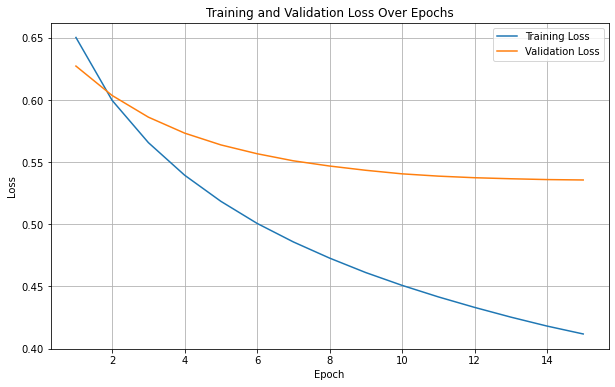

In [73]:
training_loop()


__NOTE: DON'T FORGET TO RERUN THE MODEL INITIALIZATION WHEN YOU ARE TRYING TO RUN THE MODEL MULTIPLE TIMES. IF YOU DON'T REINITIALIZE THE MODEL IT WILL CONTINUE THE TRAINING WHERE IT HAS STOPPED LAST TIME AND DOESN'T RUN FROM SRATCH!__

These lines:

```python
model = BoWClassifier(OUTPUT_DIM, INPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)
```

This will reinitialize the model!

In [74]:
def reinitialize(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.NLLLoss()
    model = model.to(device)
    criterion = criterion.to(device)

In [75]:
reinitialize(BoWClassifier(OUTPUT_DIM, INPUT_DIM))

## Add more linear layers to the model and experiment with other hyper-parameters

### More layers

Currently we only have a single linear layers in our model. We are now adding more linear layers to the model.
We also introduce a HIDDEN_SIZE parameter that will be the size of the intermediate representation between the linear layers. Also adding a RELU activation function between the linear layers.

See more:
- https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
- https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html

In [76]:
from torch import nn


class BoWDeepClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size, hidden_size):
        super(BoWDeepClassifier, self).__init__()
        # First linear layer
        self.linear1 = nn.Linear(vocab_size, hidden_size)
        # Non-linear activation function between them
        self.relu = torch.nn.ReLU()
        # Second layer
        self.linear2 = nn.Linear(hidden_size, num_labels)

    def forward(self, bow_vec, sequence_lens):
        # Run the input vector through every layer
        output = self.linear1(bow_vec)
        output = self.relu(output)
        output = self.linear2(output)

        # Get the probabilities
        return F.log_softmax(output, dim=1)

In [77]:
HIDDEN_SIZE = 200
learning_rate = 0.001
BATCH_SIZE = 64
N_EPOCHS = 15

In [78]:
model = BoWDeepClassifier(OUTPUT_DIM, INPUT_DIM, HIDDEN_SIZE)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.594 | Train Prec: 21.41% | Train Rec: 51.77% | Train Fscore: 26.88%
	 Val. Loss: 0.539 |  Val Prec: 37.05% | Val Rec: 73.40% | Val Fscore: 48.40%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.428 | Train Prec: 58.17% | Train Rec: 80.00% | Train Fscore: 66.52%
	 Val. Loss: 0.554 |  Val Prec: 48.38% | Val Rec: 68.95% | Val Fscore: 55.97%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.323 | Train Prec: 71.70% | Train Rec: 85.55% | Train Fscore: 77.50%
	 Val. Loss: 0.600 |  Val Prec: 52.76% | Val Rec: 65.10% | Val Fscore: 57.59%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.244 | Train Prec: 81.33% | Train Rec: 90.40% | Train Fscore: 85.30%
	 Val. Loss: 0.675 |  Val Prec: 50.71% | Val Rec: 63.41% | Val Fscore: 55.59%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.180 | Train Prec: 86.46% | Train Rec: 94.22% | Train Fscore: 89.90%
	 Val. Loss: 0.778 |  Val Prec: 52.48% | Val Rec: 62.85% | Val Fscore: 56.45%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.

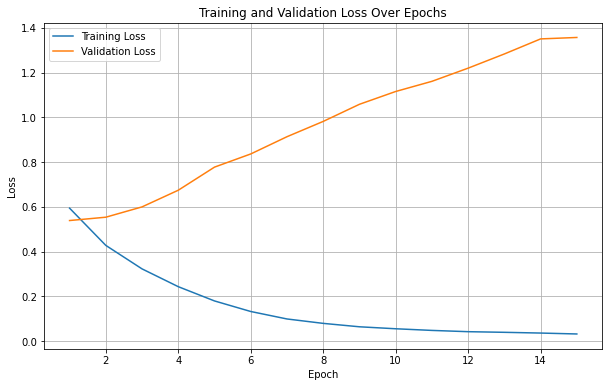

In [79]:
training_loop()

## Implement automatic early-stopping in the training loop
Early stopping is a very easy method to avoid the overfitting of your model.

We could:
- Save the training and the validation loss of the last two epochs (if you are at least in the third epoch)
- If the loss increased in the last two epoch on the training data but descreased or stagnated in the validation data, you should stop the training automatically!

In the training loop below we do a very basic early stopping after there is no improvement in validation loss on a predefined number of consecutive epochs (=patience).

In [80]:
reinitialize(BoWClassifier(OUTPUT_DIM, INPUT_DIM))

In [81]:
model = BoWDeepClassifier(OUTPUT_DIM, INPUT_DIM, HIDDEN_SIZE)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

In [82]:
def training_loop(epoch_number=15, patience=3):
    # Set an EPOCH number!
    N_EPOCHS = epoch_number
    consecutive_no_improvement = 0

    best_valid_loss = float("inf")  # ensures the 1st validation loss will always be considered better

    train_losses = []
    valid_losses = []

    # We loop forward on the epoch number
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        # Train the model on the training set using the dataloader
        train_loss, train_prec, train_rec, train_fscore = train(
            model, train_iterator, optimizer, criterion
        )
        # And validate your model on the validation set
        valid_loss, valid_prec, valid_rec, valid_fscore = evaluate(
            model, valid_iterator, criterion
        )

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # If we find a better model, we save the weights so later we may want to reload it
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            consecutive_no_improvement = 0
            torch.save(model.state_dict(), "tut1-model.pt")

        else:
            consecutive_no_improvement += 1

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train Fscore: {train_fscore*100:.2f}%"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val Prec: {valid_prec*100:.2f}% | Val Rec: {valid_rec*100:.2f}% | Val Fscore: {valid_fscore*100:.2f}%"
        )

        # Check for early stopping
        if consecutive_no_improvement >= patience:
            print(f"No improvement in validation loss for {patience} consecutive epochs. Early stopping after epoch {epoch+1}.")
            break  # Terminate training loop

    plot_losses(train_losses, valid_losses, n_epochs=epoch+1)
        
    return best_valid_loss

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.598 | Train Prec: 19.69% | Train Rec: 56.40% | Train Fscore: 24.66%
	 Val. Loss: 0.545 |  Val Prec: 40.85% | Val Rec: 68.28% | Val Fscore: 50.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.431 | Train Prec: 57.98% | Train Rec: 79.85% | Train Fscore: 66.58%
	 Val. Loss: 0.548 |  Val Prec: 48.40% | Val Rec: 68.31% | Val Fscore: 55.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.321 | Train Prec: 72.48% | Train Rec: 86.35% | Train Fscore: 78.36%
	 Val. Loss: 0.601 |  Val Prec: 52.62% | Val Rec: 63.80% | Val Fscore: 57.09%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Prec: 81.74% | Train Rec: 91.64% | Train Fscore: 85.94%
	 Val. Loss: 0.676 |  Val Prec: 50.98% | Val Rec: 62.62% | Val Fscore: 55.53%
No improvement in validation loss for 3 consecutive epochs. Early stopping after epoch 4.


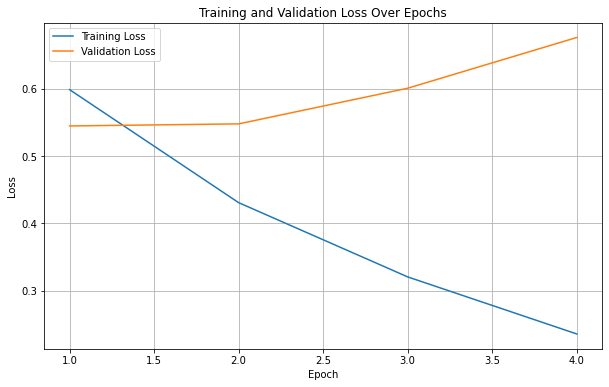

0.5445900843256996

In [83]:
training_loop()

## Handling class imbalance
Our data is imbalanced, the first class has twice the population of the second class.

One way of handling imbalanced data is to weight the loss function, so it penalizes errors on the smaller class.

Look at the documentation of the loss function: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

Set the weights based on the inverse population of the classes, so a class with fewer samples is penalized more heavily for errors.

In [84]:
tr_data.groupby("label").size()

label
0    6179
1    3089
dtype: int64

In [85]:
weights = torch.Tensor([1, 2])  # errors for class 1 will be penalised twice as heavily as errors for class 0
criterion = nn.NLLLoss(weight=weights)

## Adding an Embedding Layer to the network

- We only used Bag-of-Words representations as our features until now
- Now we will introduce an [embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer into our network.
- We will feed the words into our network one-by-one, and the layer will learn a dense vector representation for each word

![embeddingbag](https://pytorch.org/tutorials/_images/text_sentiment_ngrams_model.png)

_from pytorch.org_

In [86]:
# Get the CountVectorizer's analyzer method to get the word-id mapping
an = word_to_ix.build_analyzer()  # handles preprocessing, tokenisation and removal of stop words

In [87]:
an("hello my name is varya")

['hello', 'varya']

Get the key with maximum values in a dictionary (keys are tokens; values are number of occurrences):

`word_to_ix.vocabulary_` returns mapping of terms (tokens) to feature indices (number of occurrences)

In [88]:
max(word_to_ix.vocabulary_, key=word_to_ix.vocabulary_.get)

'🤨'

As we remember, we passed a parameter `max_features=3000` to a CountVectorizer, so our vocabulary size is 3000.

In [89]:
len(word_to_ix.vocabulary_)

3000

In [90]:
def create_input(dataset, analyzer, vocabulary):
    dataset_as_indices = []

    # We go through each tweet in the dataset
    # We need to add two additional symbols to the vocabulary
    # We have 3000 features, ranged 0-2999
    # We add 3000 as an id for the "unknown" words not among the features
    # 3001 will be the symbol for padding, but about this later!
    for tweet in dataset:
        tokens = analyzer(tweet)
        token_ids = []

        for token in tokens:
            # if the token is in the vocab, we add the id
            if token in vocabulary:
                token_ids.append(vocabulary[token])
            # else we add the id of the unknown token
            else:
                token_ids.append(3000)

        # if we removed every token during preprocessing (stopword removal, lemmatization), we add the unknown token to the list so it won't be empty
        if not token_ids:
            token_ids.append(3000)
        dataset_as_indices.append(torch.LongTensor(token_ids).to(device))

    return dataset_as_indices

In [91]:
tr_data

,id,tweet,subtask_a,subtask_b,subtask_c,label
1224,26821,You should investigate Antifa's connections ...,NOT,NaN,NaN,0
9102,93433,Love this.,NOT,NaN,NaN,0
3655,28428,She is Evil! How dare her.,OFF,TIN,IND,1
8201,73122,Because I knew it would flush out the one Du...,NOT,NaN,NaN,0
6141,89906,Hope they're brushed up on their very large n...,OFF,TIN,IND,1
...,...,...,...,...,...,...
11468,77354,Character assassinations are a survival techn...,NOT,NaN,NaN,0
7221,56585,"10) But why? Do they hate us that much?"" ...",NOT,NaN,NaN,0
1318,91693,All you do is lie. All congress does us lie. ...,OFF,TIN,IND,1
8915,77189,Did Gutierrez go help? Or is he just a blow h...,NOT,NaN,NaN,0


In [92]:
tr_data.tweet.str.len()

1224      59
9102      14
3655      28
8201      92
6141      62
        ... 
11468     63
7221     275
1318      52
8915      50
11055    167
Name: tweet, Length: 9268, dtype: int64

In [93]:
len(tr_data)

9268

In [94]:
len(val_data)

3972

In [95]:
# We add the length of the tweets so sentences with similar lengths will be next to each other
# This can be important because of padding
tr_data["length"] = tr_data.tweet.str.len()
val_data["length"] = val_data.tweet.str.len()

In [96]:
tr_data.tweet.str.len()

1224      59
9102      14
3655      28
8201      92
6141      62
        ... 
11468     63
7221     275
1318      52
8915      50
11055    167
Name: tweet, Length: 9268, dtype: int64

In [97]:
tr_data = tr_data.sort_values(by="length")
val_data = val_data.sort_values(by="length")

In [98]:
tr_data

,id,tweet,subtask_a,subtask_b,subtask_c,label,length
7843,88928,sexy,OFF,TIN,IND,1,5
8094,32539,fool,OFF,TIN,IND,1,5
9803,35439,Evil,NOT,NaN,NaN,0,5
5208,58403,Good,NOT,NaN,NaN,0,5
3160,74992,Stop,NOT,NaN,NaN,0,5
...,...,...,...,...,...,...,...
11991,23835,Haven’t seen that ...,NOT,NaN,NaN,0,320
1410,96262,...,NOT,NaN,NaN,0,325
12667,88705,...,OFF,UNT,NaN,1,326
9036,53102,...,NOT,NaN,NaN,0,326


In [99]:
# We create the dataset as ids of tokens
dataset_as_ids = create_input(tr_data.tweet, an, word_to_ix.vocabulary_)

Actually, when experimenting with different indices, you will see that many tensors that give a numeric representation of each tweet contain only one element. This is because of removal of stop words:

In [100]:
dataset_as_ids[140]

tensor([1104, 2940,    0])

Many of them contain only unknown token with an index `3000` (so, it was really important to add it, otherwise our tensor would be empty):

In [101]:
dataset_as_ids[13]

tensor([3000])

### Padding

- We didn't need to take care of input padding when using Bag-of-Words vectors
- Padding handles different sized inputs
- We can pad sequences from the left, or from the right

![padding](https://miro.medium.com/max/1218/1*zsIXWoN0_CE9PXzmY3tIjQ.png)

_image from https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657_

`torch.nn.utils.rnn.pad_sequence` takes a list of tensors as input (sequences), calculates max length, and then pads all the sequences with `padding_value` to make them all have the same length

In [102]:
from torch.nn.utils.rnn import pad_sequence

# pad_sequence will take care of the padding
# we will need to provide a padding_value to it
padded = pad_sequence(dataset_as_ids, batch_first=True, padding_value=3001)
padded

tensor([[2366, 3001, 3001,  ..., 3001, 3001, 3001],
        [1075, 3001, 3001,  ..., 3001, 3001, 3001],
        [ 963, 3001, 3001,  ..., 3001, 3001, 3001],
        ...,
        [3000, 2856,  351,  ..., 3001, 3001, 3001],
        [2453,  581, 2201,  ..., 3001, 3001, 3001],
        [1921, 1417, 2631,  ..., 3001, 3001, 3001]])

Here you can see the dimension of `padded`, so max length among the sequences is 62.

In [103]:
padded.shape

torch.Size([9268, 62])

In [104]:
def prepare_dataloader_with_padding(tr_data, val_data, word_to_ix):
    # First create the id representations of the input vectors
    # Then pad the sequences so all of the input is the same size
    # We padded texts for the whole dataset, this could have been done batch-wise also!
    tr_data_vecs = pad_sequence(
        create_input(tr_data.tweet, an, word_to_ix.vocabulary_),
        batch_first=True,
        padding_value=3001,
    )
    tr_labels = torch.LongTensor(tr_data.label.tolist()).to(device)
    tr_lens = torch.LongTensor(
        [len(i) for i in create_input(tr_data.tweet, an, word_to_ix.vocabulary_)] #len of tweets
    )
    print(f"Original Training sequence lengths before Padding: {tr_lens}")
    print(f"Training sequence lengths tensor shape: {tr_lens.shape}")

    # We also add the texts to the batches
    # This is for the Transformer models, you wont need this in the next experiments
    tr_sents = tr_data.tweet.tolist()

    val_data_vecs = pad_sequence(
        create_input(val_data.tweet, an, word_to_ix.vocabulary_),
        batch_first=True,
        padding_value=3001,
    )
    val_labels = torch.LongTensor(val_data.label.tolist()).to(device)
    val_lens = torch.LongTensor(
        [len(i) for i in create_input(val_data.tweet, an, word_to_ix.vocabulary_)]
    )

    val_sents = val_data.tweet.tolist()

    tr_data_loader = [
        (sample, label, length, sent)
        for sample, label, length, sent in zip(
            tr_data_vecs, tr_labels, tr_lens, tr_sents
        )
    ]
    val_data_loader = [
        (sample, label, length, sent)
        for sample, label, length, sent in zip(
            val_data_vecs, val_labels, val_lens, val_sents
        )
    ]

    return tr_data_loader, val_data_loader

In [105]:
tr_data_loader, val_data_loader = prepare_dataloader_with_padding(
    tr_data, val_data, word_to_ix
)

Original Training sequence lengths before Padding: tensor([ 1,  1,  1,  ..., 24, 26, 26])
Training sequence lengths tensor shape: torch.Size([9268])


In [106]:
def create_dataloader_iterators_with_padding(
    tr_data_loader, val_data_loader, BATCH_SIZE
):
    train_iterator = DataLoader(
        tr_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    valid_iterator = DataLoader(
        val_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_iterator, valid_iterator

In [107]:
train_iterator, valid_iterator = create_dataloader_iterators_with_padding(
    tr_data_loader, val_data_loader, BATCH_SIZE
)

`next(iter(train_iterator))` returns a single batch of data (=batch size)

In [108]:
next(iter(train_iterator))

[tensor([[1171,  924, 2106,  ..., 3001, 3001, 3001],
         [ 608, 1646,    0,  ..., 3001, 3001, 3001],
         [2277,  188,   21,  ..., 3001, 3001, 3001],
         ...,
         [1156, 1605, 3001,  ..., 3001, 3001, 3001],
         [2830, 1152,  242,  ..., 3001, 3001, 3001],
         [2648, 1835,  789,  ..., 3001, 3001, 3001]]),
 tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
         0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]),
 tensor([ 9, 28, 10, 31,  3,  2, 32, 37, 28, 14, 30, 10, 19,  6,  7, 14,  8, 17,
          2,  3, 24, 30,  3,  3,  2, 14, 10,  7,  9, 27, 24, 31,  5, 18, 16, 16,
         10,  9, 13, 15,  8, 16,  3, 18, 35,  5, 10,  7,  4,  5,  7,  1, 36, 33,
          5,  7, 15, 34, 18,  7, 22,  2,  8,  6]),
 ("  Grab em by the pussy!!!  What's the problem?",
  "Confirm the MAN! THE LEFT WING ACTIVIST IS A LIAR WHO'S STORY CHANGES! NO HARD EVIDENCE! #Christ

In [109]:
samples, labels, lengths, sents = next(iter(train_iterator))
print(f'Dimension of a tensor with data samples on each iteration (2D tensor of shape (BATCH_SIZE, max_sequence_length)): {samples.shape}')
print(f'Number of tweets in the batch: {len(sents)}')
print(samples[1]) # 2nd sample with X unique ids that are then padded to tensor len=62
print(lengths[1]) # original length of the 2nd sample (before padding)
print(sents[1])

Dimension of a tensor with data samples on each iteration (2D tensor of shape (BATCH_SIZE, max_sequence_length)): torch.Size([64, 62])
Number of tweets in the batch: 64
tensor([1108, 1558, 2830, 1224, 1974, 3000, 3000,  243, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001])
tensor(8)
 fucking liar she was happy to play kate nash when you asked her


![embedding](https://github.com/bentrevett/pytorch-sentiment-analysis/raw/b4efbefa47672174394a8b6a27d4e7bc193bc224/assets/sentiment8.png)

_Image from bentrevett_: (BoW) model with an embedding layer and a pooling operation

Max Pooling:

`[[0.1, 0.3, 0.2],`  # "I"

 `[0.5, 0.7, 0.6],`  # "hate"

 `[0.2, 0.1, 0.3],`  # "this"
 
 `[0.4, 0.9, 0.8]]`  # "film"

Max pooling (along the sequence dimension): `[0.5, 0.9, 0.8]` represents the whole tweet




In [110]:
from torch import nn
import numpy as np


class BoWClassifierWithEmbedding(nn.Module):
    def __init__(self, num_labels, vocab_size, embedding_dim):
        super(BoWClassifierWithEmbedding, self).__init__()

        # We define the embedding layer here
        # It will convert a list of ids: [1, 50, 64, 2006]
        # Into a list of vectors, one for each word
        # The embedding layer will learn the vectors from the contexts
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=3001)
        # We could also load precomputed embeddings, e.g. GloVe, in some cases we don't want to train the embedding layer
        # In this case we enable the training
        self.embedding.weight.requires_grad = True

        self.linear = nn.Linear(embedding_dim, num_labels)

    def forward(self, text, sequence_lens):
        # First we create the embedded vectors
        embedded = self.embedding(text)  # dim=64x62x100 (batch_size x seq_len x embedding_dim)
        #print(embedded.shape)
        #print(embedded.shape[1])
        # We need a pooling to convert a list of embedded words to a sentence vector
        # We could have chosen different pooling, e.g. min, max, average..
        # With LSTM we also do a pooling, just smarter
        pooled = F.max_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)  # dim=64x100 (batch_size x embedding_dim)
        #print(pooled.shape)
        return F.log_softmax(self.linear(pooled), dim=1)

In [111]:
INPUT_DIM = VOCAB_SIZE + 2  # 3002
OUTPUT_DIM = 2
EMBEDDING_DIM = 100  # embedding layer will have an embedding vector for each of the 3000 vocabulary words, plus vectors for <UNK> and <PAD>
HIDDEN_DIM = 20
criterion = nn.NLLLoss()

model = BoWClassifierWithEmbedding(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM)
#model = LSTMClassifier(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)

In [112]:
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.654 | Train Prec: 9.29% | Train Rec: 34.76% | Train Fscore: 13.42%
	 Val. Loss: 0.642 |  Val Prec: 4.48% | Val Rec: 34.94% | Val Fscore: 7.31%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.624 | Train Prec: 10.13% | Train Rec: 46.03% | Train Fscore: 15.41%
	 Val. Loss: 0.642 |  Val Prec: 2.98% | Val Rec: 21.17% | Val Fscore: 4.96%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.606 | Train Prec: 16.80% | Train Rec: 55.48% | Train Fscore: 23.50%
	 Val. Loss: 0.614 |  Val Prec: 13.04% | Val Rec: 55.93% | Val Fscore: 20.12%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.579 | Train Prec: 21.33% | Train Rec: 70.11% | Train Fscore: 31.07%
	 Val. Loss: 0.603 |  Val Prec: 17.02% | Val Rec: 60.91% | Val Fscore: 25.47%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.558 | Train Prec: 30.94% | Train Rec: 74.04% | Train Fscore: 41.66%
	 Val. Loss: 0.594 |  Val Prec: 19.10% | Val Rec: 67.83% | Val Fscore: 28.52%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.531 |

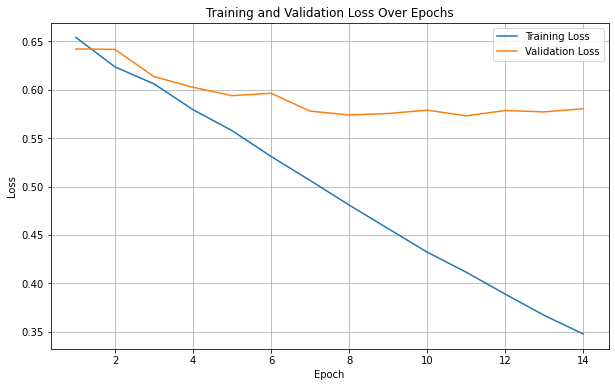

0.5730739907612876

In [113]:
training_loop(epoch_number=15)

## Standard RNNs & LSTMs

Unrolled RNN (image source: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

![unrolled_rnn1](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

Repeating module in the standard RNN (image source: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

![rnn_module](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

Repeating module in the LSTM (image source: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

![repeating_module_lstm](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Output of the LSTM layer..

![lstm](https://i.stack.imgur.com/SjnTl.png)

_image from stackoverflow_

In [114]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size, embedding_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=3001)
        self.embedding.weight.requires_grad = True

        # Define the LSTM layer
        # Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            batch_first=True,
            num_layers=1,
            bidirectional=False,
        )
        self.linear = nn.Linear(hidden_dim, num_labels)
        # Dropout to overcome overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, text, sequence_lens):
        embedded = self.embedding(text)

        # To ensure LSTM doesn't learn gradients for the id of the padding symbol
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, sequence_lens, enforce_sorted=False, batch_first=True
        )
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(
            packed_outputs, batch_first=True
        )

        # We use the last hidden vector from LSTM
        y = self.linear(h[-1])
        log_probs = F.log_softmax(y, dim=1)
        return log_probs

In [115]:
INPUT_DIM = VOCAB_SIZE + 2
OUTPUT_DIM = 2
EMBEDDING_DIM = 100
HIDDEN_DIM = 20
criterion = nn.NLLLoss()

#model = BoWClassifierWithEmbedding(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM)
model = LSTMClassifier(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)

In [116]:
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.635 | Train Prec: 0.17% | Train Rec: 2.76% | Train Fscore: 0.32%
	 Val. Loss: 0.628 |  Val Prec: 0.88% | Val Rec: 15.87% | Val Fscore: 1.66%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.618 | Train Prec: 3.08% | Train Rec: 35.93% | Train Fscore: 5.51%
	 Val. Loss: 0.613 |  Val Prec: 8.39% | Val Rec: 56.22% | Val Fscore: 13.92%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.568 | Train Prec: 28.33% | Train Rec: 73.51% | Train Fscore: 38.62%
	 Val. Loss: 0.589 |  Val Prec: 35.24% | Val Rec: 59.53% | Val Fscore: 43.23%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.492 | Train Prec: 49.85% | Train Rec: 74.88% | Train Fscore: 58.88%
	 Val. Loss: 0.590 |  Val Prec: 34.72% | Val Rec: 65.04% | Val Fscore: 43.99%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.425 | Train Prec: 60.43% | Train Rec: 79.93% | Train Fscore: 67.89%
	 Val. Loss: 0.605 |  Val Prec: 47.99% | Val Rec: 60.33% | Val Fscore: 52.54%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.368 | Tr

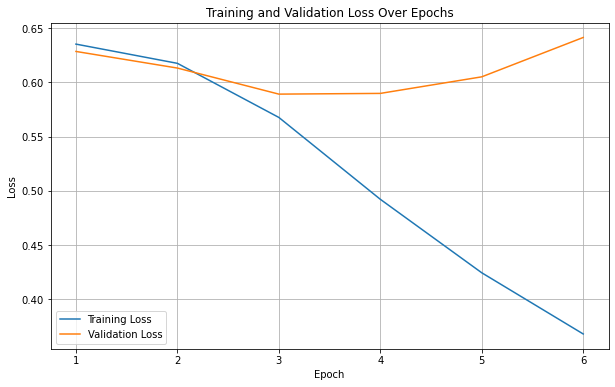

0.5891430524606553

In [117]:
training_loop(epoch_number=15)

Interested in LSTMs? Check out the recent paper by the group of Sepp Hochreiter [xLSTM: Extended Long Short-Term Memory](https://arxiv.org/abs/2405.04517)
- Exponential Gating
- New memory structure to address long-term dependencies problem of RNNs and initial LSTMs
- mLSTM: address the problem of lacking parallelisation in LSTMs

#### CNN for NLP

- works with input of fixed length (to handle it we need padding: fill sequences of different length with tokens that do not contain any meaning)
- kernels (filters) in the visualisation below correspond to kernels for bigrams, trigrams and and tetragrams (2 for each type of kernels)
- In Computer Vision, our filters slide over local patches of an image, but in NLP we typically use filters that slide over full rows of the matrix (words). Thus, the second dimension of our filters is usually the same as the number of columns of the input matrix

CNN architecture for NLP introduced in [Zhang et al. A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification. 2015](https://arxiv.org/pdf/1510.03820.pdf)

## Transformers

## Attention mechanism in a nutshell

To recap: seq2seq: encoder-decoder architecture with 2 RNNs without an attention block (image source: [medium article](https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346))

![encoder_decoder_rnn](https://miro.medium.com/v2/resize:fit:720/format:webp/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg)

##### Attention mechanism and neural machine translation

Machine translation

fascinating history that started more than 100 years ago (translating machine of Troyanskii, Georgetown–IBM experiment, ...): some of these experiments were driven by the Cold War

- rule-based systems
- statistical machine translation (phrase-based statistical machine translation is SOTA until 2016)
- NN based approaches without attention mechanism
- RNN based Encoder-Decoder architecture with attention mechanism (introduced in 2014 in the paper [Bengio et al. Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)): read [this Google Blog](https://blog.research.google/2016/09/a-neural-network-for-machine.html) from 2016 on machine translation system they introduced back then, namely Google Neural Machine Translation (GNMT) that contained 8 RNN layers in the encoder and decoder + attention mechanism
- Attention is all you need :D


![attention_encoder_decoder](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KrCUK30Y1R7TV7xE-ltcpg.png)

Image source: [medium article](https://medium.com/data-science-community-srm/understanding-encoders-decoders-with-attention-based-mechanism-c1eb7164c581)

### Problems with recurrent neural networks:

Recall that we used recurrent neural cells, specifically LSTMs to encode a list of vectors into a sentence vector.

- Problem 1. No parallelism

        - LSTMs are recurrent, they rely on their left and right history, so the symbols need to be processed in order -> no parallelism.

- Problem 2. Long-range dependencies

        - Long-range dependencies are not infrequent in NLP.

        - "The people/person who called and wanted to rent your house when you go away next year are/is from California" -- Miller & Chomsky 1963

        - LSTMs have a problem capturing these because there are too many backpropagation steps between the symbols.

## Transformers

Good explanation of transformer architecture: https://jalammar.github.io/illustrated-transformer/

![transformer_architecture](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

Image source: https://machinelearningmastery.com

- Attention is all you need: no convolutions or recurrences are used. Introduction of multi-headed self-attention. 

"The animal didn't cross the street because it was too tired" -- We want self-attention to associate *it* with *animal*

![self_attention](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*maneqIvralwRZWf0g3hS5w.png)

Image source: [towardsdatascience](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021#4c16)

![self_attention_detailed](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Rv_pntt-N2WL7LMbIptHxQ.png)

Image source: [towardsdatascience](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021#4c16)

Introduced in [Attention Is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) by Vaswani et al., 2017

Transformers solve Problem 1 by relying purely on attention instead of recurrence.

Not having recurrent connections means that sequence position no longer matters.

Recurrence is replaced by self-attention.

- Transformers are available in the __transformers__ Python package: https://github.com/huggingface/transformers.
- There are thousands of pretrained transformers models in different languages and with different architectures.
- With the huggingface package there is a unified interface to download and use all the models. Browse https://huggingface.co/models for more!
- There is also a great blog post to understand the architecture of transformers: https://jalammar.github.io/illustrated-transformer/

### BERT

[BERT](https://www.aclweb.org/anthology/N19-1423/): Pre-training of Deep Bidirectional Transformers for Language Understanding by Devlin et al. 2018

[BERTology](https://huggingface.co/transformers/bertology.html) is the nickname for the growing amount of BERT-related research.

BERT trains a transformer model on two tasks:

- Masked language model:

    - 15% of the tokens' wordpieces are selected at the beginning.
    - 80% of those are replaced with [MASK],
    - 10% are replaced with a random token,
    - 10% are kept intact.

- Next sentence prediction:
    - Are sentences A and B consecutive sentences?
    - Generate 50-50%.
    - Binary classification task.
    

### Training, Finetuning BERT

- BERT models are (masked-)language models that were usually trained on large corporas.

- e.g. BERT base model was trained on BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia.
- vocab_size=30522 for BERT base 

#### Finetuning

- Get a trained BERT model.
- Add a small classification layer on top (typically a 2-layer MLP).
- Train BERT along with the classification layer on an annotated dataset.
- Much smaller than the data BERT was trained on
- Another option: freeze BERT and train the classification layer only.
    - Easier training regime.
    - Smaller memory footprint.
    - Worse performance.

<img src="https://production-media.paperswithcode.com/methods/new_BERT_Overall.jpg" alt="finetune" width="800px"/>

In [119]:
!pip install transformers

### WordPiece tokenizer
- BERT has its own tokenizer
- All inputs must be tokenized with BERT
- You don't need to remove stopwords, lemmatize, preprocess the input for BERT

- It is a middle ground between word and character tokenization.

- Static vocabulary:
    - Special tokens: [CLS], [SEP], [MASK], [UNK]
    - It tokenizes everything, falling back to characters and [UNK] if necessary

In [ ]:
!pip3 install emoji==0.6.0

In [134]:
from transformers import BertTokenizer, AutoTokenizer

In [148]:
from transformers import BertTokenizer

# Load a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

text = "I love Python 🐍 and data analysis 📊!"

# Tokenize the text
tokens = tokenizer.tokenize(text)
print(tokens)

['i', 'love', 'python', '[UNK]', 'and', 'data', 'analysis', '[UNK]', '!']


In [149]:
tokenizer("There are black cats and black dogs.", "Another sentence.")

{'input_ids': [101, 2045, 2024, 2304, 8870, 1998, 2304, 6077, 1012, 102, 2178, 6251, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

=> [CLS] Sentence 1 [SEP] Sentence 2 [SEP]

100: [UNK] (Unknown token)

101: [CLS] (Classification Token)

102: [SEP] (Separator Token): The [CLS] token is special in BERT as it is used to aggregate information from the entire sequence. Its output embedding (from the last layer of the model) is often used for classification tasks (e.g., sentiment analysis, sentence-pair classification).

103: [MASK] (Masked Token)

0: [PAD] (Padding)


In [150]:
print(type(tokenizer))
print(len(tokenizer.get_vocab()))

tokenizer.tokenize("His full name is Fyodor Mikhailovich Dostoevsky")

<class 'transformers.models.bert.tokenization_bert.BertTokenizer'>
30522


['his',
 'full',
 'name',
 'is',
 'f',
 '##yo',
 '##dor',
 'mikhail',
 '##ovich',
 'dos',
 '##to',
 '##evsky']

Now, let's have a look at how another tokeniser works:

In [151]:
from transformers import BertTokenizer

# Load a BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")  # The vinai/bertweet-base model does not use BertTokenizer. it uses a RoBERTa-like tokenizer => AutoTokenizer for simplicity

text = "I love Python 🐍 and data analysis 📊!"

# Tokenize the text
tokens = tokenizer.tokenize(text)
print(tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['I', 'love', 'Python', '🐍', 'and', 'data', 'analysis', '📊@@', '!']


In [152]:
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [153]:
print(type(tokenizer))
print(len(tokenizer.get_vocab()))

tokenizer.tokenize("His full name is Fyodor Mikhailovich Dostoevsky")

<class 'transformers.models.bertweet.tokenization_bertweet.BertweetTokenizer'>
64001


['His',
 'full',
 'name',
 'is',
 'Fy@@',
 'odor',
 'Mikha@@',
 'i@@',
 'lov@@',
 'ich',
 'Do@@',
 'sto@@',
 'ev@@',
 'sky']

In [154]:
tokenizer("There are black cats and black dogs.", "Another sentence.")

{'input_ids': [0, 326, 41, 583, 3490, 13, 583, 10638, 32188, 2, 2, 1311, 31707, 11725, 4, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Train a BertForSequenceClassification model on the dataset

In [127]:
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification, TrainingArguments, RobertaForSequenceClassification, Trainer

__BertForSequenceClassification__ is a helper class to train transformer-based BERT models. It puts a classification layer on top of a pretrained model.

Read more in the documentation: https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification

In [128]:
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
#_ = model.to(device)

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)
_ = model.to(device)

#model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)
#_ = model.to(device)

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [129]:
# We only want to finetune the classification layer on top of BERT
for p in model.base_model.parameters():
    p.requires_grad = False

In [156]:
for p in model.classifier.parameters():
    print(p.requires_grad)  # Check trainable status


True
True
True
True


In [157]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
params = list(model.named_parameters())

print(f"The BERT model has {len(params)} different named parameters.")

print("==== Embedding Layer ====\n")

for p in params[0:5]:
    print(f"{p[0]} {str(tuple(p[1].size()))}")

print("\n==== First Transformer Encoder Block ====\n")  

for p in params[5:21]:
    print(f"{p[0]} {str(tuple(p[1].size()))}")

print("\n==== Output Layer ====\n")

for p in params[-4:]:
    print(f"{p[0]} {str(tuple(p[1].size()))}")

The BERT model has 201 different named parameters.
==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight (64001, 768)
roberta.embeddings.position_embeddings.weight (130, 768)
roberta.embeddings.token_type_embeddings.weight (1, 768)
roberta.embeddings.LayerNorm.weight (768,)
roberta.embeddings.LayerNorm.bias (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight (768, 768)
roberta.encoder.layer.0.attention.self.query.bias (768,)
roberta.encoder.layer.0.attention.self.key.weight (768, 768)
roberta.encoder.layer.0.attention.self.key.bias (768,)
roberta.encoder.layer.0.attention.self.value.weight (768, 768)
roberta.encoder.layer.0.attention.self.value.bias (768,)
roberta.encoder.layer.0.attention.output.dense.weight (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias (768,)
roberta.encoder.layer.0.attention.output.LayerNorm.weight (768,)
roberta.encoder.layer.0.attention.output.LayerNorm.bias (768,)
roberta.encoder.layer.0.interme

In [158]:
N_EPOCHS = 5
optimizer = optim.Adam(model.parameters())

#weights = torch.Tensor([1, 2])
#criterion = nn.CrossEntropyLoss(weight=weights)

In [159]:
tr_data_loader, val_data_loader = prepare_dataloader_with_padding(
    tr_data, val_data, word_to_ix
)

train_iterator, valid_iterator = create_dataloader_iterators_with_padding(
    tr_data_loader, val_data_loader, BATCH_SIZE
)

Original Training sequence lengths before Padding: tensor([ 1,  1,  1,  ..., 24, 26, 26])
Training sequence lengths tensor shape: torch.Size([9268])


In [133]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_epoch_loss = 0
    train_epoch_prec = 0
    train_epoch_recall = 0
    train_epoch_fscore = 0
    model.train()

    # We use our own iterator but now use the raw texts instead of the ID tokens
    for train_batch in train_iterator:
        labels = train_batch[1]
        texts = train_batch[3]

        optimizer.zero_grad()

        # We use BERT's own tokenizer on raw texts
        # Check the documentation: https://huggingface.co/transformers/main_classes/tokenizer.html
        encoded = tokenizer(
            texts,
            truncation=True,
            max_length=128,
            padding=True,
            return_tensors="pt",
        )

        # BERT converts texts into IDs of its own vocabulary
        input_ids = encoded["input_ids"].to(device)
        # Mask to avoid performing attention on padding token indices.
        attention_mask = encoded["attention_mask"].to(device)

        # Run the model
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs[0] #negative log likelihood loss


        predictions = outputs[1]
        #print(predictions)
        prec, recall, fscore = calculate_performance(predictions, labels)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_prec += prec.item()
        train_epoch_recall += recall.item()
        train_epoch_fscore += fscore.item()

    train_loss = train_epoch_loss / len(train_iterator)
    train_prec = train_epoch_prec / len(train_iterator)
    train_rec = train_epoch_recall / len(train_iterator)
    train_fscore = train_epoch_fscore / len(train_iterator)

    # And validate your model on the validation set
    valid_epoch_loss = 0
    valid_epoch_prec = 0
    valid_epoch_recall = 0
    valid_epoch_fscore = 0
    model.eval()

    with torch.no_grad():
        for valid_batch in valid_iterator:
            labels = valid_batch[1]
            texts = valid_batch[3]

            encoded = tokenizer(
                texts,
                truncation=True,
                max_length=128,
                padding=True,
                return_tensors="pt",
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            predictions = outputs[1]
            prec, recall, fscore = calculate_performance(predictions, labels)

            # We add batch-wise loss to the epoch-wise loss
            valid_epoch_loss += loss.item()
            valid_epoch_prec += prec.item()
            valid_epoch_recall += recall.item()
            valid_epoch_fscore += fscore.item()

    valid_loss = valid_epoch_loss / len(valid_iterator)
    valid_prec = valid_epoch_prec / len(valid_iterator)
    valid_rec = valid_epoch_recall / len(valid_iterator)
    valid_fscore = valid_epoch_fscore / len(valid_iterator)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(
        f"\tTrain Loss: {train_loss:.3f} | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train Fscore: {train_fscore*100:.2f}%"
    )
    print(
        f"\t Val. Loss: {valid_loss:.3f} |  Val Prec: {valid_prec*100:.2f}% | Val Rec: {valid_rec*100:.2f}% | Val Fscore: {valid_fscore*100:.2f}%"
    )

Epoch: 01 | Epoch Time: 3m 35s
	Train Loss: 0.615 | Train Prec: 16.23% | Train Rec: 47.95% | Train Fscore: 21.39%
	 Val. Loss: 0.614 |  Val Prec: 3.62% | Val Rec: 39.68% | Val Fscore: 6.49%
Epoch: 02 | Epoch Time: 3m 36s
	Train Loss: 0.589 | Train Prec: 25.76% | Train Rec: 59.76% | Train Fscore: 32.85%
	 Val. Loss: 0.562 |  Val Prec: 19.65% | Val Rec: 65.77% | Val Fscore: 28.23%
Epoch: 03 | Epoch Time: 3m 36s
	Train Loss: 0.588 | Train Prec: 29.11% | Train Rec: 59.52% | Train Fscore: 35.21%
	 Val. Loss: 0.558 |  Val Prec: 21.38% | Val Rec: 67.98% | Val Fscore: 29.68%
Epoch: 04 | Epoch Time: 3m 37s
	Train Loss: 0.580 | Train Prec: 29.99% | Train Rec: 61.62% | Train Fscore: 38.01%
	 Val. Loss: 0.592 |  Val Prec: 61.01% | Val Rec: 55.81% | Val Fscore: 56.84%
Epoch: 05 | Epoch Time: 3m 34s
	Train Loss: 0.579 | Train Prec: 31.08% | Train Rec: 61.37% | Train Fscore: 38.56%
	 Val. Loss: 0.552 |  Val Prec: 23.84% | Val Rec: 67.30% | Val Fscore: 32.72%


## Same experiment with HuggingFace

In this experiment we will also look at how you can track your experiments with [mlflow](https://mlflow.org)

In [ ]:
!pip install -U accelerate
!pip install -U transformers

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

In [ ]:
pip install safetensors

In [ ]:
!pip install wandb

Check the train and val data again

In [163]:
tr_data

,id,tweet,subtask_a,subtask_b,subtask_c,label,length
7843,88928,sexy,OFF,TIN,IND,1,5
8094,32539,fool,OFF,TIN,IND,1,5
9803,35439,Evil,NOT,NaN,NaN,0,5
5208,58403,Good,NOT,NaN,NaN,0,5
3160,74992,Stop,NOT,NaN,NaN,0,5
...,...,...,...,...,...,...,...
11991,23835,Haven’t seen that ...,NOT,NaN,NaN,0,320
1410,96262,...,NOT,NaN,NaN,0,325
12667,88705,...,OFF,UNT,NaN,1,326
9036,53102,...,NOT,NaN,NaN,0,326


In [164]:
val_data

,id,tweet,subtask_a,subtask_b,subtask_c,label,length
10467,26126,Good,NOT,NaN,NaN,0,5
8166,37849,Bull,NOT,NaN,NaN,0,5
658,73253,Sexy,NOT,NaN,NaN,0,5
396,23159,Ouch!,OFF,UNT,NaN,1,6
738,90997,Sucks,OFF,TIN,IND,1,6
...,...,...,...,...,...,...,...
6677,83999,...,NOT,NaN,NaN,0,297
582,33099,You are suggesting that it i...,NOT,NaN,NaN,0,297
10311,82164,It is always same-trash Trump &amp; conservat...,OFF,TIN,GRP,1,300
1994,67217,My Dad didn’t die so ANYONE could disres...,NOT,NaN,NaN,0,301


In [165]:
#convert a df column into a list of strings
train_texts = tr_data.tweet.tolist()

#convert a df column into a list of strings
train_labels = tr_data.label.tolist()

#convert a df column into a list of strings
val_texts = val_data.tweet.tolist()

#convert a df column into a list of strings
val_labels = val_data.label.tolist()

In [166]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [167]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [168]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

In [169]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Now, we finetune our BERT model with different hyperparameters. Before we had `batch_size=64`, default batch size in the HugggingFace class `transformers.TrainingArguments`is 8. We also change the learnung rate.

##### Change of hyperparameters
- `batch_size=8`
- `learning_rate=5e-5`
##### Keep track of experiments with Weights & Biases

Note: if you get an error similar to `ImportError: Using the Trainer with PyTorch requires accelerate>=0.20.1: Please run pip install transformers[torch] or pip install accelerate -U` when running code on the colab, please make sure you run the command `!pip install accelerate -U`. After that do the following:
1. In the top menu click **Runtime** → **Restart Runtime**
2. Do not rerun any cells with !pip install in them
3. Rerun all the other code cells that refer to the experiment using Huggingface and you should be good to go!

In [171]:
import wandb

In [173]:
from datetime import datetime

# Get the current date
current_date = datetime.now().strftime("%Y%m%d")  # Format: YYYYMMDD
current_date

'20241121'

In [ ]:
from transformers import EarlyStoppingCallback


In [174]:
wandb.init(project="bert-finetuning", name=f"bert-base-uncased-semeval-{current_date}")

training_args = TrainingArguments(
    output_dir=f"./results_bertbaseuncased_semeval_{current_date}",
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir=f"./logs_bertbaseuncased_semeval_{current_date}",            # directory for storing logs
    load_best_model_at_end=True,
    greater_is_better=False,
    logging_steps=10,
    metric_for_best_model='eval_loss', 
    report_to="wandb"
    )

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping with patience of 3

)

trainer.train()

results = trainer.evaluate()

# Log evaluation results to wandb
wandb.log(results)

trainer.save_model(f"./saved_model_bertbaseuncased_semeval_{current_date}")

# End the wandb run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/varya/.netrc


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5795 [00:00<?, ?it/s]

{'loss': 0.6786, 'learning_rate': 4.99137187230371e-05, 'epoch': 0.01}
{'loss': 0.6162, 'learning_rate': 4.9827437446074206e-05, 'epoch': 0.02}
{'loss': 0.5703, 'learning_rate': 4.9741156169111304e-05, 'epoch': 0.03}
{'loss': 0.6416, 'learning_rate': 4.965487489214841e-05, 'epoch': 0.03}
{'loss': 0.5648, 'learning_rate': 4.956859361518551e-05, 'epoch': 0.04}
{'loss': 0.6967, 'learning_rate': 4.9482312338222606e-05, 'epoch': 0.05}
{'loss': 0.7278, 'learning_rate': 4.9396031061259704e-05, 'epoch': 0.06}
{'loss': 0.5138, 'learning_rate': 4.930974978429681e-05, 'epoch': 0.07}
{'loss': 0.5801, 'learning_rate': 4.922346850733391e-05, 'epoch': 0.08}
{'loss': 0.5883, 'learning_rate': 4.913718723037101e-05, 'epoch': 0.09}
{'loss': 0.4589, 'learning_rate': 4.905090595340811e-05, 'epoch': 0.09}
{'loss': 0.4452, 'learning_rate': 4.8964624676445215e-05, 'epoch': 0.1}
{'loss': 0.4523, 'learning_rate': 4.8878343399482314e-05, 'epoch': 0.11}
{'loss': 0.5424, 'learning_rate': 4.879206212251942e-05, 'ep

***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./results_bertbaseuncased_semeval_20241121/checkpoint-1159
Configuration saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-1159/config.json


{'eval_loss': 0.4632123112678528, 'eval_accuracy': 0.7973313192346425, 'eval_f1': 0.7973313192346425, 'eval_precision': 0.7973313192346425, 'eval_recall': 0.7973313192346425, 'eval_runtime': 92.6498, 'eval_samples_per_second': 42.871, 'eval_steps_per_second': 5.364, 'epoch': 1.0}


Model weights saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-1159/pytorch_model.bin


{'loss': 0.6077, 'learning_rate': 3.999137187230371e-05, 'epoch': 1.0}
{'loss': 0.4055, 'learning_rate': 3.990509059534081e-05, 'epoch': 1.01}
{'loss': 0.4048, 'learning_rate': 3.9818809318377916e-05, 'epoch': 1.02}
{'loss': 0.5151, 'learning_rate': 3.9732528041415015e-05, 'epoch': 1.03}
{'loss': 0.4342, 'learning_rate': 3.964624676445211e-05, 'epoch': 1.04}
{'loss': 0.3551, 'learning_rate': 3.955996548748921e-05, 'epoch': 1.04}
{'loss': 0.3317, 'learning_rate': 3.9473684210526316e-05, 'epoch': 1.05}
{'loss': 0.322, 'learning_rate': 3.9387402933563415e-05, 'epoch': 1.06}
{'loss': 0.4853, 'learning_rate': 3.930112165660052e-05, 'epoch': 1.07}
{'loss': 0.3071, 'learning_rate': 3.921484037963762e-05, 'epoch': 1.08}
{'loss': 0.4704, 'learning_rate': 3.912855910267472e-05, 'epoch': 1.09}
{'loss': 0.5042, 'learning_rate': 3.904227782571182e-05, 'epoch': 1.1}
{'loss': 0.3608, 'learning_rate': 3.8955996548748926e-05, 'epoch': 1.1}
{'loss': 0.4311, 'learning_rate': 3.8869715271786024e-05, 'epoc

***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./results_bertbaseuncased_semeval_20241121/checkpoint-2318
Configuration saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-2318/config.json


{'eval_loss': 0.4728225767612457, 'eval_accuracy': 0.7922960725075529, 'eval_f1': 0.7922960725075529, 'eval_precision': 0.7922960725075529, 'eval_recall': 0.7922960725075529, 'eval_runtime': 90.9978, 'eval_samples_per_second': 43.649, 'eval_steps_per_second': 5.462, 'epoch': 2.0}


Model weights saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-2318/pytorch_model.bin


{'loss': 0.3157, 'learning_rate': 2.9982743744607424e-05, 'epoch': 2.0}
{'loss': 0.3352, 'learning_rate': 2.9896462467644522e-05, 'epoch': 2.01}
{'loss': 0.3922, 'learning_rate': 2.9810181190681624e-05, 'epoch': 2.02}
{'loss': 0.3754, 'learning_rate': 2.9723899913718722e-05, 'epoch': 2.03}
{'loss': 0.2701, 'learning_rate': 2.9637618636755827e-05, 'epoch': 2.04}
{'loss': 0.3336, 'learning_rate': 2.9551337359792925e-05, 'epoch': 2.04}
{'loss': 0.4324, 'learning_rate': 2.9465056082830027e-05, 'epoch': 2.05}
{'loss': 0.3449, 'learning_rate': 2.9378774805867125e-05, 'epoch': 2.06}
{'loss': 0.256, 'learning_rate': 2.929249352890423e-05, 'epoch': 2.07}
{'loss': 0.4488, 'learning_rate': 2.920621225194133e-05, 'epoch': 2.08}
{'loss': 0.2768, 'learning_rate': 2.9119930974978434e-05, 'epoch': 2.09}
{'loss': 0.3318, 'learning_rate': 2.9033649698015532e-05, 'epoch': 2.1}
{'loss': 0.1521, 'learning_rate': 2.8947368421052634e-05, 'epoch': 2.11}
{'loss': 0.3156, 'learning_rate': 2.8861087144089732e-05

***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./results_bertbaseuncased_semeval_20241121/checkpoint-3477
Configuration saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-3477/config.json


{'eval_loss': 0.7189241647720337, 'eval_accuracy': 0.7787009063444109, 'eval_f1': 0.7787009063444109, 'eval_precision': 0.7787009063444109, 'eval_recall': 0.7787009063444109, 'eval_runtime': 99.4873, 'eval_samples_per_second': 39.925, 'eval_steps_per_second': 4.996, 'epoch': 3.0}


Model weights saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-3477/pytorch_model.bin


{'loss': 0.1308, 'learning_rate': 1.997411561691113e-05, 'epoch': 3.0}
{'loss': 0.2291, 'learning_rate': 1.9887834339948233e-05, 'epoch': 3.01}
{'loss': 0.3434, 'learning_rate': 1.9801553062985334e-05, 'epoch': 3.02}
{'loss': 0.3311, 'learning_rate': 1.9715271786022436e-05, 'epoch': 3.03}
{'loss': 0.0327, 'learning_rate': 1.9628990509059538e-05, 'epoch': 3.04}
{'loss': 0.2874, 'learning_rate': 1.9542709232096636e-05, 'epoch': 3.05}
{'loss': 0.226, 'learning_rate': 1.9456427955133738e-05, 'epoch': 3.05}
{'loss': 0.3563, 'learning_rate': 1.937014667817084e-05, 'epoch': 3.06}
{'loss': 0.1512, 'learning_rate': 1.928386540120794e-05, 'epoch': 3.07}
{'loss': 0.4432, 'learning_rate': 1.9197584124245043e-05, 'epoch': 3.08}
{'loss': 0.3456, 'learning_rate': 1.911130284728214e-05, 'epoch': 3.09}
{'loss': 0.2192, 'learning_rate': 1.902502157031924e-05, 'epoch': 3.1}
{'loss': 0.2364, 'learning_rate': 1.893874029335634e-05, 'epoch': 3.11}
{'loss': 0.4294, 'learning_rate': 1.8852459016393442e-05, 'e

***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./results_bertbaseuncased_semeval_20241121/checkpoint-4636
Configuration saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-4636/config.json


{'eval_loss': 0.9521754384040833, 'eval_accuracy': 0.7792044310171199, 'eval_f1': 0.7792044310171199, 'eval_precision': 0.7792044310171199, 'eval_recall': 0.7792044310171199, 'eval_runtime': 88.6361, 'eval_samples_per_second': 44.812, 'eval_steps_per_second': 5.607, 'epoch': 4.0}


Model weights saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-4636/pytorch_model.bin


{'loss': 0.327, 'learning_rate': 9.96548748921484e-06, 'epoch': 4.0}
{'loss': 0.1451, 'learning_rate': 9.879206212251942e-06, 'epoch': 4.01}
{'loss': 0.0598, 'learning_rate': 9.792924935289043e-06, 'epoch': 4.02}
{'loss': 0.2584, 'learning_rate': 9.706643658326143e-06, 'epoch': 4.03}
{'loss': 0.1389, 'learning_rate': 9.620362381363245e-06, 'epoch': 4.04}
{'loss': 0.0151, 'learning_rate': 9.534081104400345e-06, 'epoch': 4.05}
{'loss': 0.0629, 'learning_rate': 9.447799827437447e-06, 'epoch': 4.06}
{'loss': 0.1749, 'learning_rate': 9.361518550474548e-06, 'epoch': 4.06}
{'loss': 0.1228, 'learning_rate': 9.275237273511648e-06, 'epoch': 4.07}
{'loss': 0.3219, 'learning_rate': 9.18895599654875e-06, 'epoch': 4.08}
{'loss': 0.206, 'learning_rate': 9.10267471958585e-06, 'epoch': 4.09}
{'loss': 0.1279, 'learning_rate': 9.016393442622952e-06, 'epoch': 4.1}
{'loss': 0.2467, 'learning_rate': 8.930112165660053e-06, 'epoch': 4.11}
{'loss': 0.1294, 'learning_rate': 8.843830888697153e-06, 'epoch': 4.12}

***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./results_bertbaseuncased_semeval_20241121/checkpoint-5795
Configuration saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-5795/config.json


{'eval_loss': 1.022975206375122, 'eval_accuracy': 0.7824773413897281, 'eval_f1': 0.7824773413897281, 'eval_precision': 0.7824773413897281, 'eval_recall': 0.7824773413897281, 'eval_runtime': 93.7351, 'eval_samples_per_second': 42.375, 'eval_steps_per_second': 5.302, 'epoch': 5.0}


Model weights saved in ./results_bertbaseuncased_semeval_20241121/checkpoint-5795/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_bertbaseuncased_semeval_20241121/checkpoint-1159 (score: 0.4632123112678528).
***** Running Evaluation *****
  Num examples = 3972
  Batch size = 8


{'train_runtime': 4431.4448, 'train_samples_per_second': 10.457, 'train_steps_per_second': 1.308, 'train_loss': 0.3369064765496178, 'epoch': 5.0}


  0%|          | 0/497 [00:00<?, ?it/s]

Saving model checkpoint to ./saved_model_bertbaseuncased_semeval_20241121
Configuration saved in ./saved_model_bertbaseuncased_semeval_20241121/config.json
Model weights saved in ./saved_model_bertbaseuncased_semeval_20241121/pytorch_model.bin


epoch,▁
eval/accuracy,█▆▁▁▂█
eval/f1,█▆▁▁▂█
eval/loss,▁▁▄▇█▁
eval/precision,█▆▁▁▂█
eval/recall,█▆▁▁▂█
eval/runtime,▅▄█▃▅▁
eval/samples_per_second,▄▅▁▆▄█
eval/steps_per_second,▄▅▁▆▄█
eval_accuracy,▁
eval_f1,▁


Do not forget to add early stopping :)